### Percobaan 3

Ekualisasi, Mean dan Sobel

In [1]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

## Data Loading

In [2]:
data = []
labels = []
file_name = []

for sub_folder in os.listdir("dataset\\"):
    sub_folder_files = os.listdir(os.path.join("dataset\\", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("dataset\\", sub_folder, filename)
        img = cv.imread(img_path)
        if img is not None:
            # Ambil channel hijau dari gambar
            green = img[:, :, 1]
            green = cv.resize(green, (150, 150)) # Resize gambar yag diambil
            green = green.astype(np.uint8)

            # img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            # img = cv.resize(img, (150, 150))  # Resize ke ukuran tetap
            # img = img.astype(np.uint8)

            data.append(green)
            labels.append(sub_folder)
            name = os.path.splitext(filename)[0]
            file_name.append(filename)

data = np.array(data)
labels = np.array(labels)

## Data Preparation

### Define Preprocessing

In [3]:
def histogram_equalization(img_gray):
    hist, bins = np.histogram(img_gray.flatten(), bins=256, range=[0,255])
    cdf = hist.cumsum()
    cdf_normalized = cdf * 255 / cdf[-1]
    img_eq = np.interp(img_gray.flatten(), bins[:-1], cdf_normalized)
    return img_eq.reshape(img_gray.shape).astype(np.uint8)

def mean_filter(img, kernel_size=3):
    pad = kernel_size // 2
    padded = np.pad(img, pad, mode='constant', constant_values=0)
    result = np.zeros_like(img, dtype=np.float32)  # Gunakan float32 untuk akurasi

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            window = padded[i:i+kernel_size, j:j+kernel_size]
            total = np.sum(window)
            result[i, j] = total / (kernel_size * kernel_size)
    
    return np.clip(result, 0, 255).astype(np.uint8)  # Clip dan konversi ke uint8


In [4]:
Sx = np.array([[-1,0,1],
               [-2,0,2],
               [-1,0,1]])

Sy = np.array([[1,2,1],
               [0,0,0],
               [-1,-2,-1]])

def sobel(img_gray):
   
    img_float = img_gray.astype(np.float32)

    rows, cols = img_float.shape

    Gx = np.zeros_like(img_float, dtype=np.float32)
    Gy = np.zeros_like(img_float, dtype=np.float32)

    kernel_size = 3
    pad_width = kernel_size // 2  

    padded_img = np.pad(img_float, pad_width, mode='symmetric')

    for i in range(rows):
        for j in range(cols):
            window = padded_img[i : i + kernel_size, j : j + kernel_size]

            Gx[i, j] = np.sum(window * Sx)
            Gy[i, j] = np.sum(window * Sy)

    G_magnitude = np.hypot(Gx, Gy)

    max_magnitude = np.max(G_magnitude)

    if max_magnitude > 0:
        G_normalized = (G_magnitude / max_magnitude) * 255.0
    else:
        G_normalized = G_magnitude 
        
    sobel_output = np.clip(G_normalized, 0, 255).astype(np.uint8)

    return sobel_output

## Preprocessing

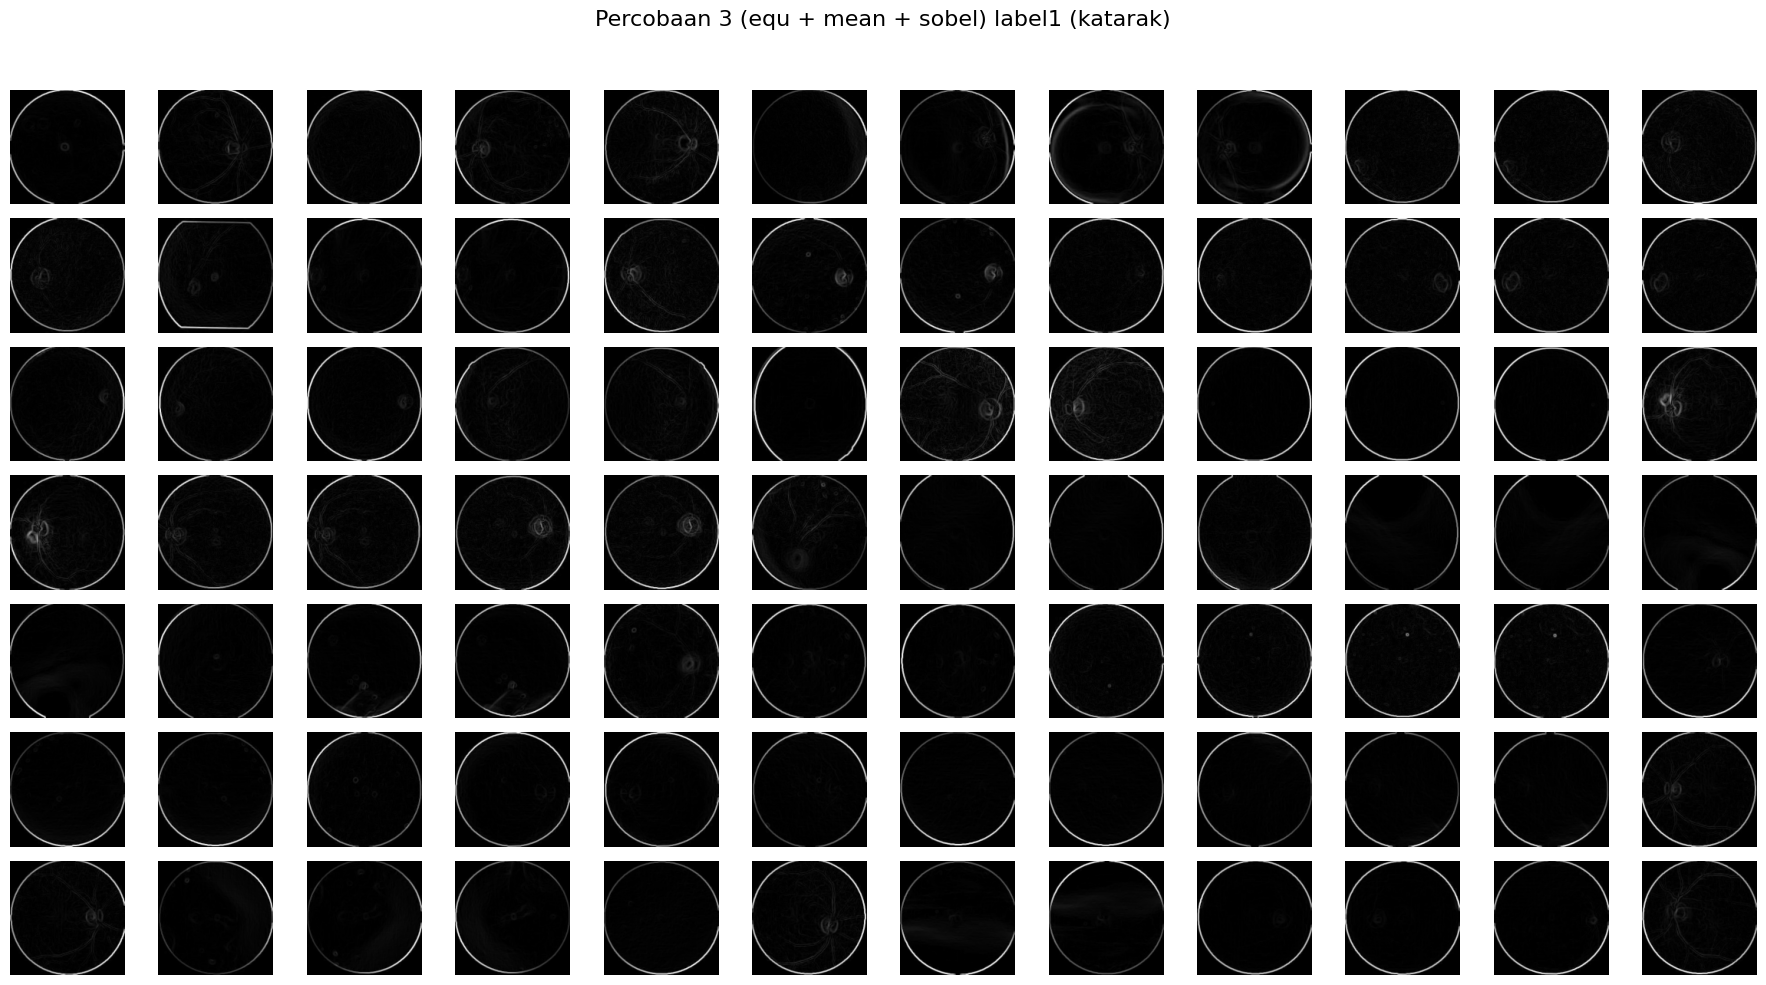

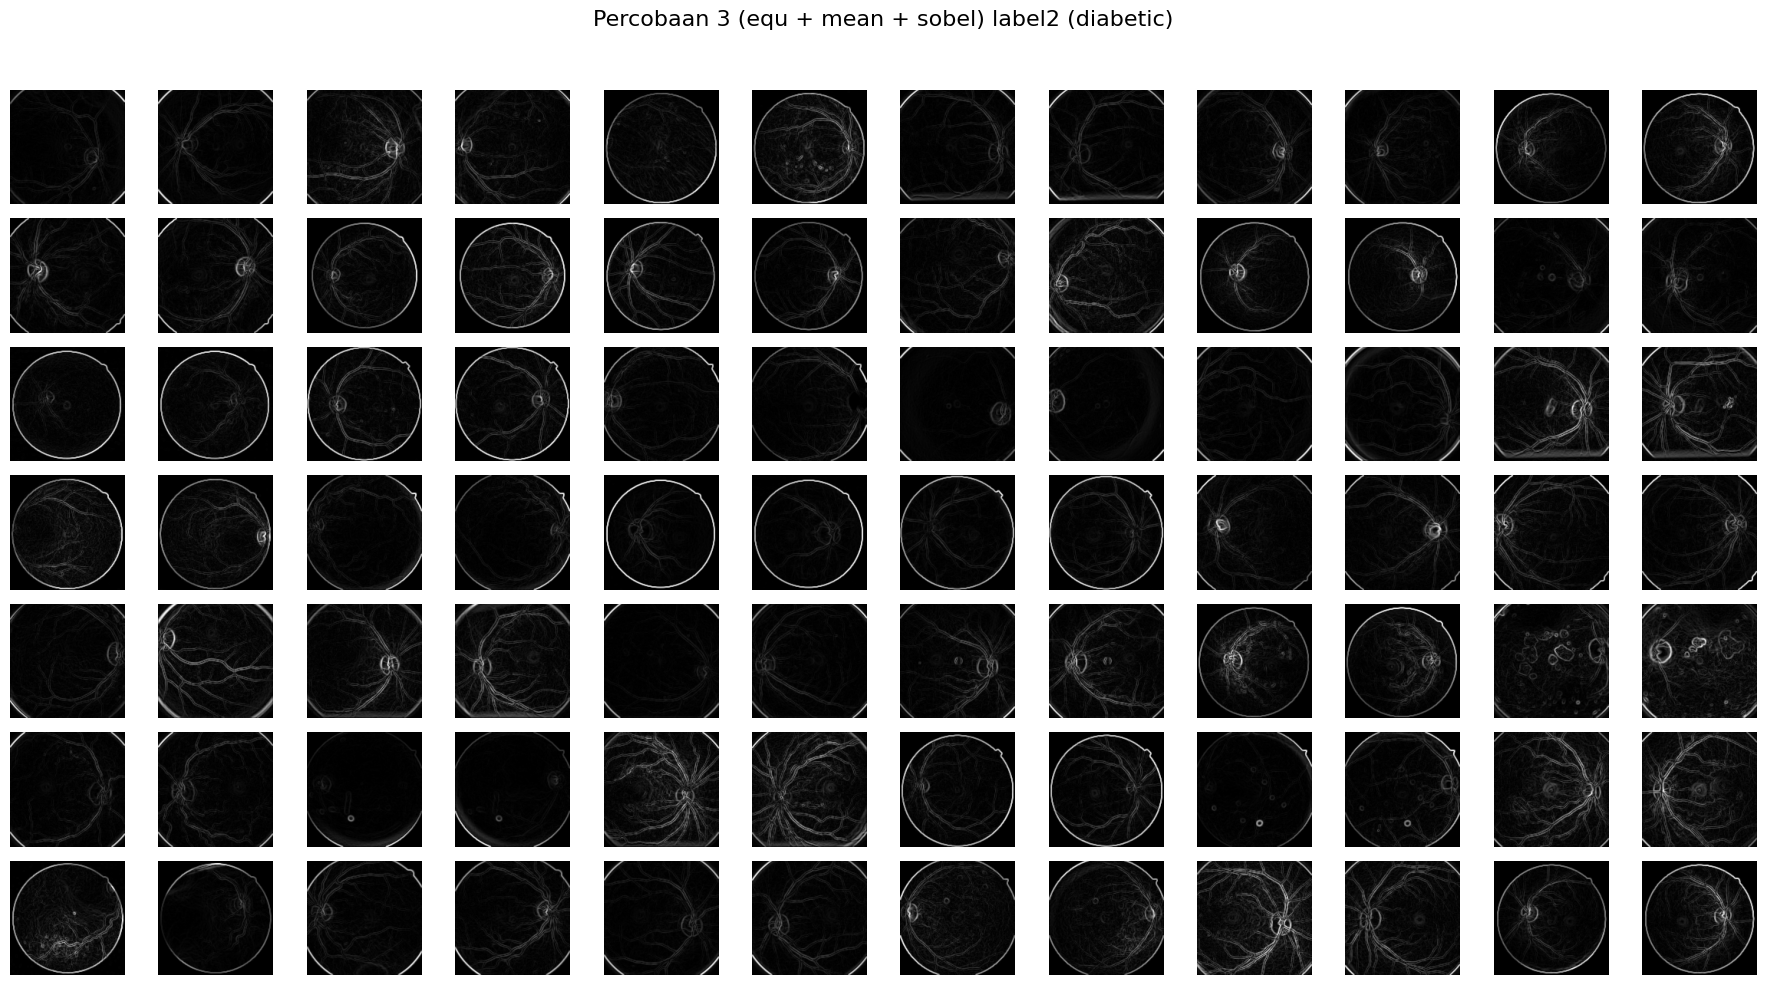

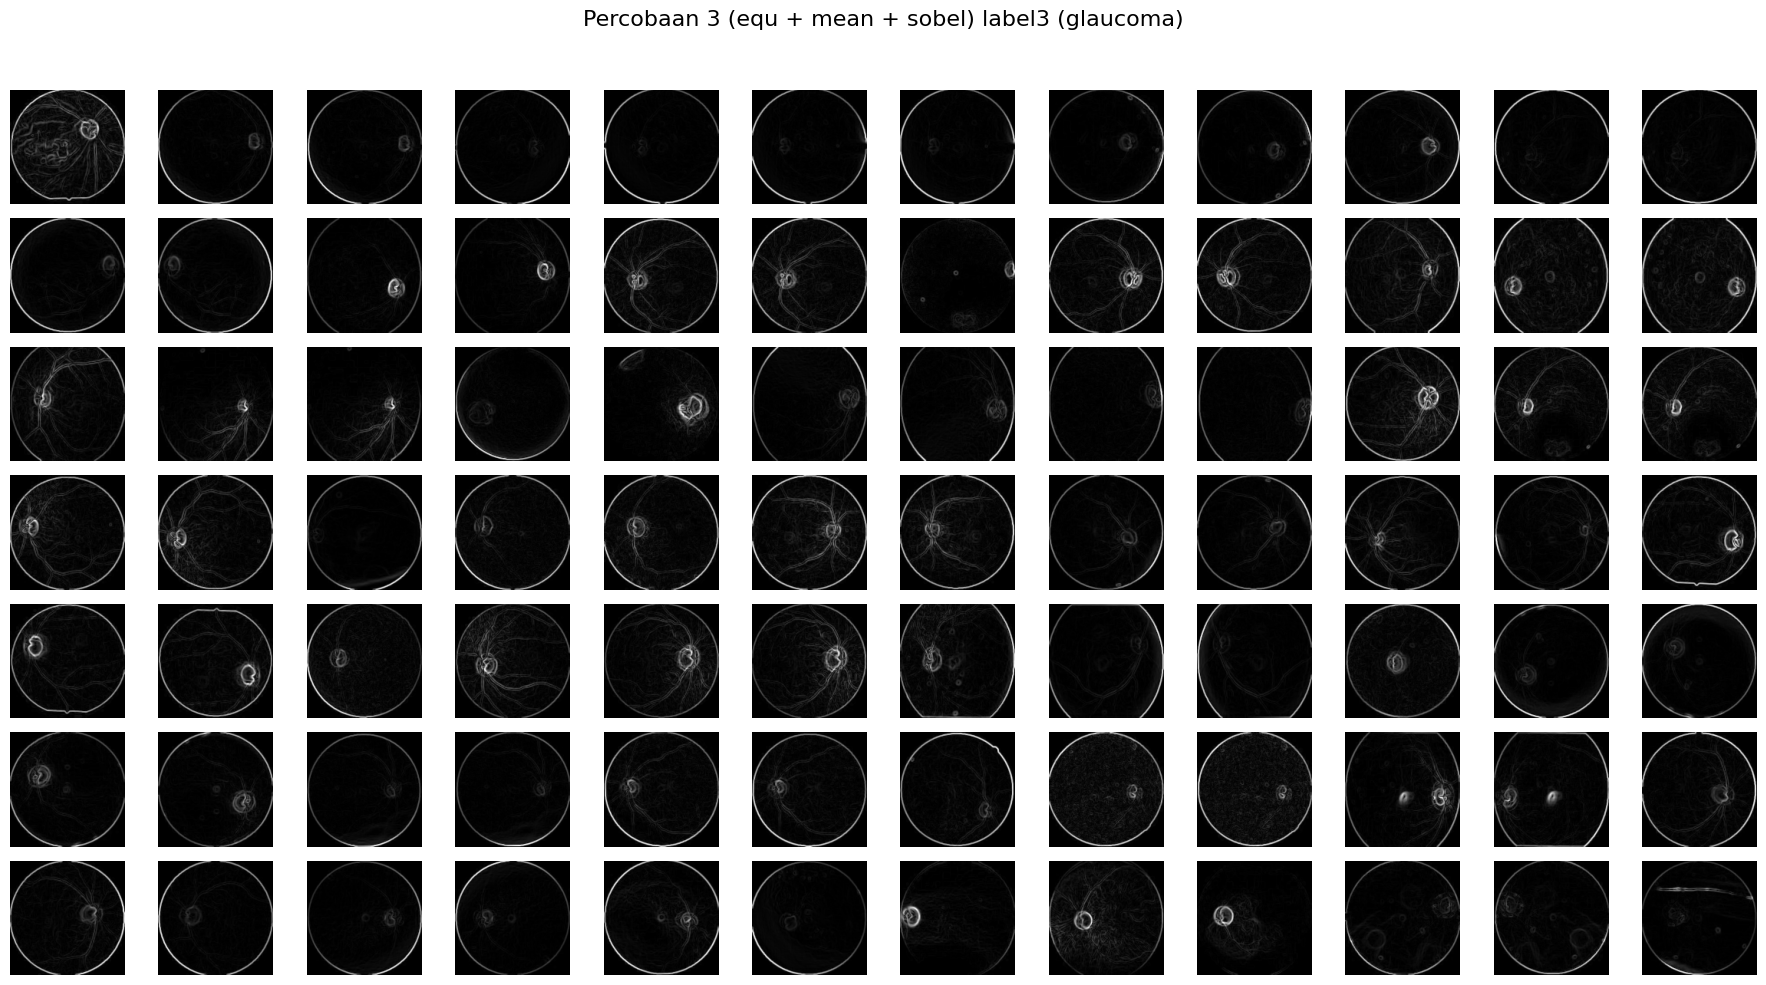

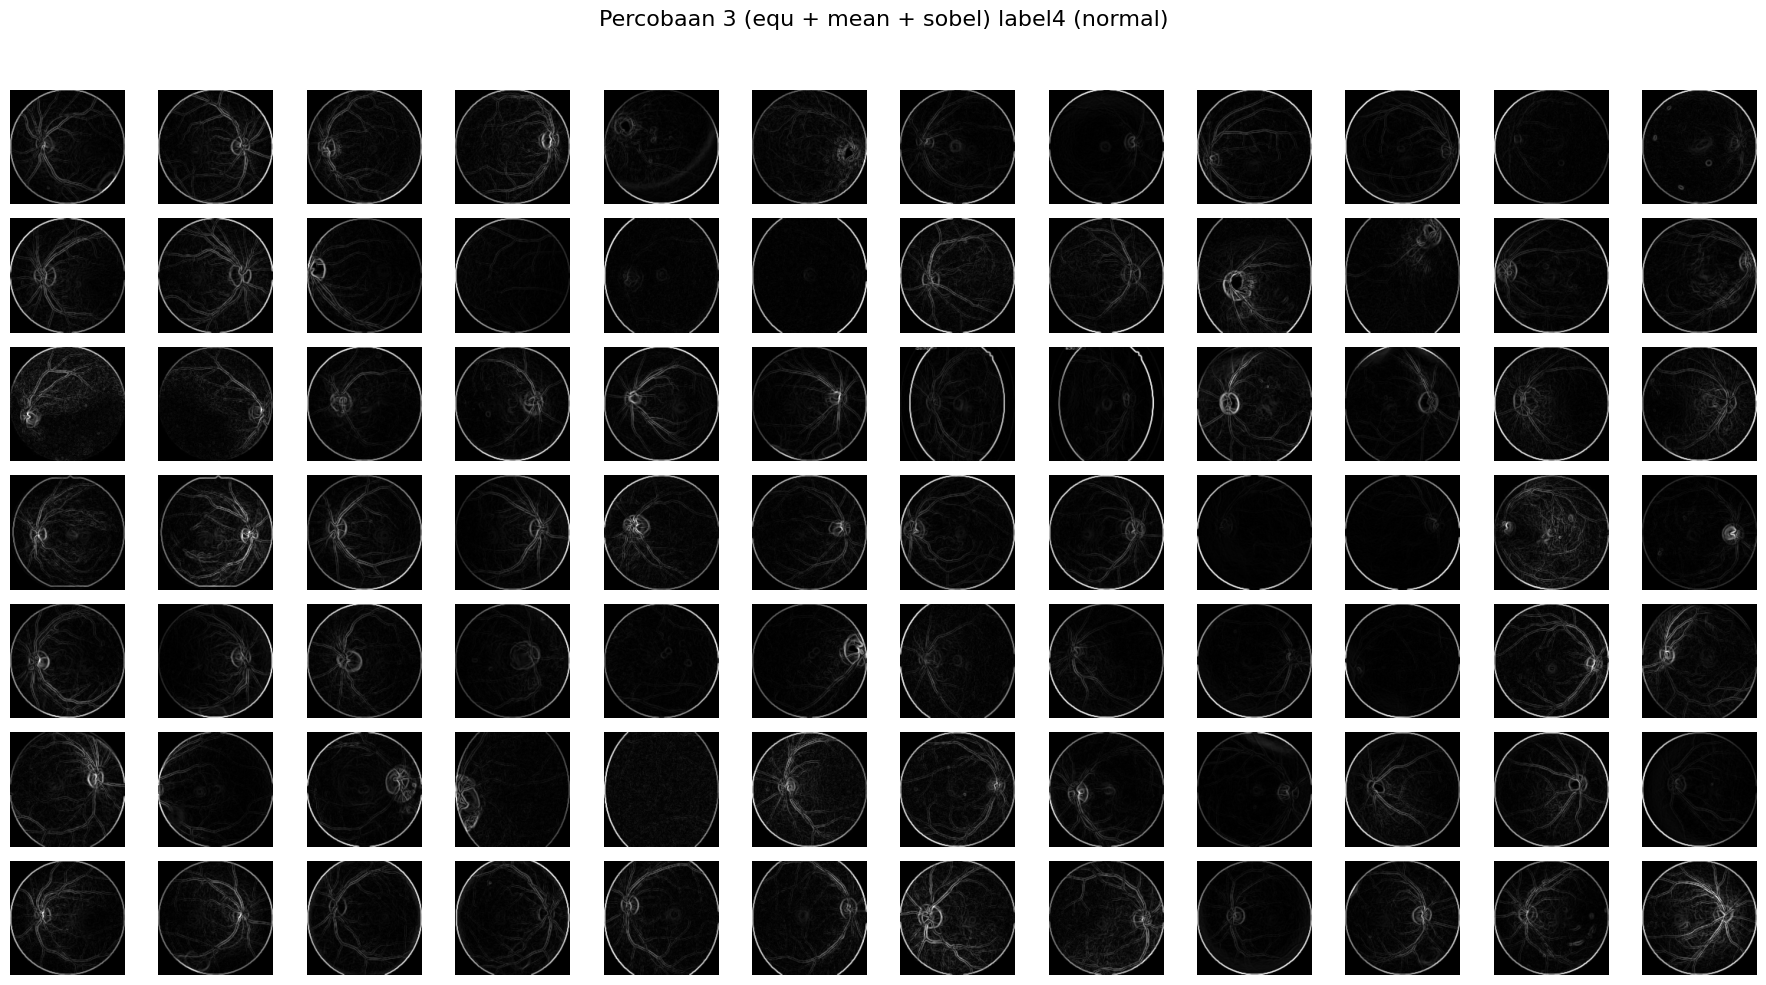

In [5]:
def percobaan2(green):
    img_eq = histogram_equalization(green)
    img_mean = mean_filter(img_eq)
    return img_mean

def percobaan3(img_mean):
    img_sobel = sobel(img_mean)
    return img_sobel

dataPreprocessed = [percobaan3(img) for img in data]  

unique_labels = sorted(set(labels))


for label in unique_labels:
    # Ambil semua indeks gambar dari label ini
    idxs = [j for j, l in enumerate(labels) if l == label]
    
    # Buat grid 7x12 (cukup untuk 84 gambar, 7*12 = 84)
    fig, axs = plt.subplots(7, 12, figsize=(18, 10))
    fig.suptitle(f'Percobaan 3 (equ + mean + sobel) {label}', fontsize=16)
    
    for k in range(84):
        row = k // 12
        col = k % 12
        ax = axs[row][col]
        ax.imshow(dataPreprocessed[idxs[k]], cmap='gray')
        ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # beri ruang untuk judul
    plt.show()

## Ekstraksi Fitur

In [6]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    
    return glcm

In [7]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [8]:
# Fungsi ekstraksi fitur untuk list citra
def ekstrak_fitur_glcm(data, nama_prepro):
    fitur_list = []
    for img in data:
        img_u8 = img.astype(np.uint8)
        m = glcm(img_u8, 0)  # derajat 0
        
        fitur = {
            'contrast': contrast(m),
            'correlation': correlation(m),
            'energy': energy(m),
            'homogeneity': homogenity(m),
            'dissimilarity': dissimilarity(m),
            'ASM': ASM(m),
            'entropy': entropyGlcm(m)
        }
        fitur_list.append(fitur)

    df = pd.DataFrame(fitur_list)
    df['tahap'] = nama_prepro
    return df

df2 = ekstrak_fitur_glcm(dataPreprocessed, 'percobaan2')
display(df2)

contrast  correlation    energy  homogeneity  dissimilarity       ASM  \
0    382.520492     0.813063  0.267452     0.663892       5.063848  0.071530   
1    384.583669     0.771555  0.174427     0.456879       6.120224  0.030425   
2    492.058747     0.788171  0.169606     0.472274       6.258300  0.028766   
3    264.071096     0.762638  0.177572     0.458767       4.853199  0.031532   
4    372.822461     0.780979  0.154824     0.393536       6.688501  0.023970   
..          ...          ...       ...          ...            ...       ...   
331  411.551230     0.729789  0.153794     0.279117      10.144519  0.023653   
332  443.458658     0.766180  0.193314     0.451098       6.524519  0.037370   
333  452.220358     0.739229  0.173112     0.340320       8.658389  0.029968   
334  423.423221     0.757201  0.173896     0.347283       8.684161  0.030240   
335  828.920045     0.737153  0.166666     0.280909      13.801029  0.027778   

      entropy       tahap  
0    3.745237  percobaan2  
1    5.071964  percobaan2  
2    4.746009  percobaan2  
3    5.059780  percobaan2  
4    5.545851  percobaan2  
..        ...         ...  
331  6.799425  percobaan2  
332  5.371561  percobaan2  
333  6.179523  percobaan2  
334  6.213467  percobaan2  
335  7.087455  percobaan2  

[336 rows x 8 columns]

In [9]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []

for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

for i in range(len(data)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)



## Hasil Ekstraksi to CSV

In [10]:
features = []

for i in range(len(dataPreprocessed)):
    fitur = [
        contrast(Derajat0[i]), contrast(Derajat45[i]), contrast(Derajat90[i]), contrast(Derajat135[i]),
        dissimilarity(Derajat0[i]), dissimilarity(Derajat45[i]), dissimilarity(Derajat90[i]), dissimilarity(Derajat135[i]),
        homogenity(Derajat0[i]), homogenity(Derajat45[i]), homogenity(Derajat90[i]), homogenity(Derajat135[i]),
        entropyGlcm(Derajat0[i]), entropyGlcm(Derajat45[i]), entropyGlcm(Derajat90[i]), entropyGlcm(Derajat135[i]),
        ASM(Derajat0[i]), ASM(Derajat45[i]), ASM(Derajat90[i]), ASM(Derajat135[i]),
        energy(Derajat0[i]), energy(Derajat45[i]), energy(Derajat90[i]), energy(Derajat135[i]),
        correlation(Derajat0[i]), correlation(Derajat45[i]), correlation(Derajat90[i]), correlation(Derajat135[i]),
    ]
    features.append(fitur)

# Buat dataframe
columns = [
    "contrast_0", "contrast_45", "contrast_90", "contrast_135",
    "dissimilarity_0", "dissimilarity_45", "dissimilarity_90", "dissimilarity_135",
    "homogeneity_0", "homogeneity_45", "homogeneity_90", "homogeneity_135",
    "entropy_0", "entropy_45", "entropy_90", "entropy_135",
    "ASM_0", "ASM_45", "ASM_90", "ASM_135",
    "energy_0", "energy_45", "energy_90", "energy_135",
    "correlation_0", "correlation_45", "correlation_90", "correlation_135"
]

df_fitur = pd.DataFrame(features, columns=columns)


In [11]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_percobaan3.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_percobaan3.csv')
hasilEkstrak


Filename             Label   Contrast0   Contrast45  Contrast90  \
0     _0_4015166.jpg  label1 (katarak)  382.520492   632.518130  415.531812   
1    _10_3215668.jpg  label1 (katarak)  384.583669   570.984325  341.703803   
2    _11_7158929.jpg  label1 (katarak)  492.058747   810.381019  458.982729   
3    _12_5233869.jpg  label1 (katarak)  264.071096   374.163551  216.319284   
4    _13_3987009.jpg  label1 (katarak)  372.822461   626.340120  349.696510   
..               ...               ...         ...          ...         ...   
331      8_right.jpg   label4 (normal)  411.551230   654.704518  390.541163   
332     939_left.jpg   label4 (normal)  443.458658   739.267330  438.176152   
333    939_right.jpg   label4 (normal)  452.220358   725.546462  399.161790   
334     951_left.jpg   label4 (normal)  423.423221   754.926940  443.195973   
335    951_right.jpg   label4 (normal)  828.920045  1318.817621  887.965145   

     Contrast135  Homogeneity0  Homogeneity45  Homogeneity90  Homogeneity135  \
0     728.440386      0.663892       0.585602       0.631545        0.574960   
1     646.444800      0.456879       0.405490       0.455718        0.400839   
2     817.985091      0.472274       0.421966       0.485187        0.422369   
3     420.043827      0.458767       0.401757       0.465373        0.396766   
4     600.864691      0.393536       0.354164       0.409063        0.353788   
..           ...           ...            ...            ...             ...   
331   568.690915      0.279117       0.258765       0.279011        0.258890   
332   717.669925      0.451098       0.402919       0.446217        0.405515   
333   639.551867      0.340320       0.313838       0.337976        0.306078   
334   613.263772      0.347283       0.319805       0.350985        0.318414   
335  1233.225620      0.280909       0.252465       0.276081        0.251818   

     ...     ASM90    ASM135   Energy0  Energy45  Energy90  Energy135  \
0    ...  0.067572  0.057332  0.267452  0.241315  0.259947   0.239440   
1    ...  0.030295  0.026695  0.174427  0.163881  0.174056   0.163385   
2    ...  0.029345  0.025686  0.169606  0.160635  0.171304   0.160267   
3    ...  0.031882  0.027011  0.177572  0.164724  0.178556   0.164349   
4    ...  0.024152  0.021640  0.154824  0.146668  0.155409   0.147104   
..   ...       ...       ...       ...       ...       ...        ...   
331  ...  0.023681  0.022156  0.153794  0.149580  0.153886   0.148849   
332  ...  0.037127  0.034399  0.193314  0.185335  0.192684   0.185469   
333  ...  0.030020  0.028167  0.173112  0.168256  0.173262   0.167830   
334  ...  0.030348  0.028693  0.173896  0.169924  0.174207   0.169390   
335  ...  0.027751  0.025719  0.166666  0.160327  0.166586   0.160373   

     Correlation0  Correlation45  Correlation90  Correlation135  
0        0.813063       0.688022       0.795005        0.640711  
1        0.771555       0.659703       0.797429        0.614730  
2        0.788171       0.649358       0.800955        0.646068  
3        0.762638       0.664487       0.808519        0.623346  
4        0.780979       0.632292       0.796144        0.647248  
..            ...            ...            ...             ...  
331      0.729789       0.568150       0.743780        0.624886  
332      0.766180       0.603712       0.769150        0.615290  
333      0.739229       0.578194       0.771052        0.628188  
334      0.757201       0.561268       0.744700        0.643597  
335      0.737153       0.578436       0.718470        0.605796  

[336 rows x 30 columns]

## Feature Selection

### Correlation

<Axes: >

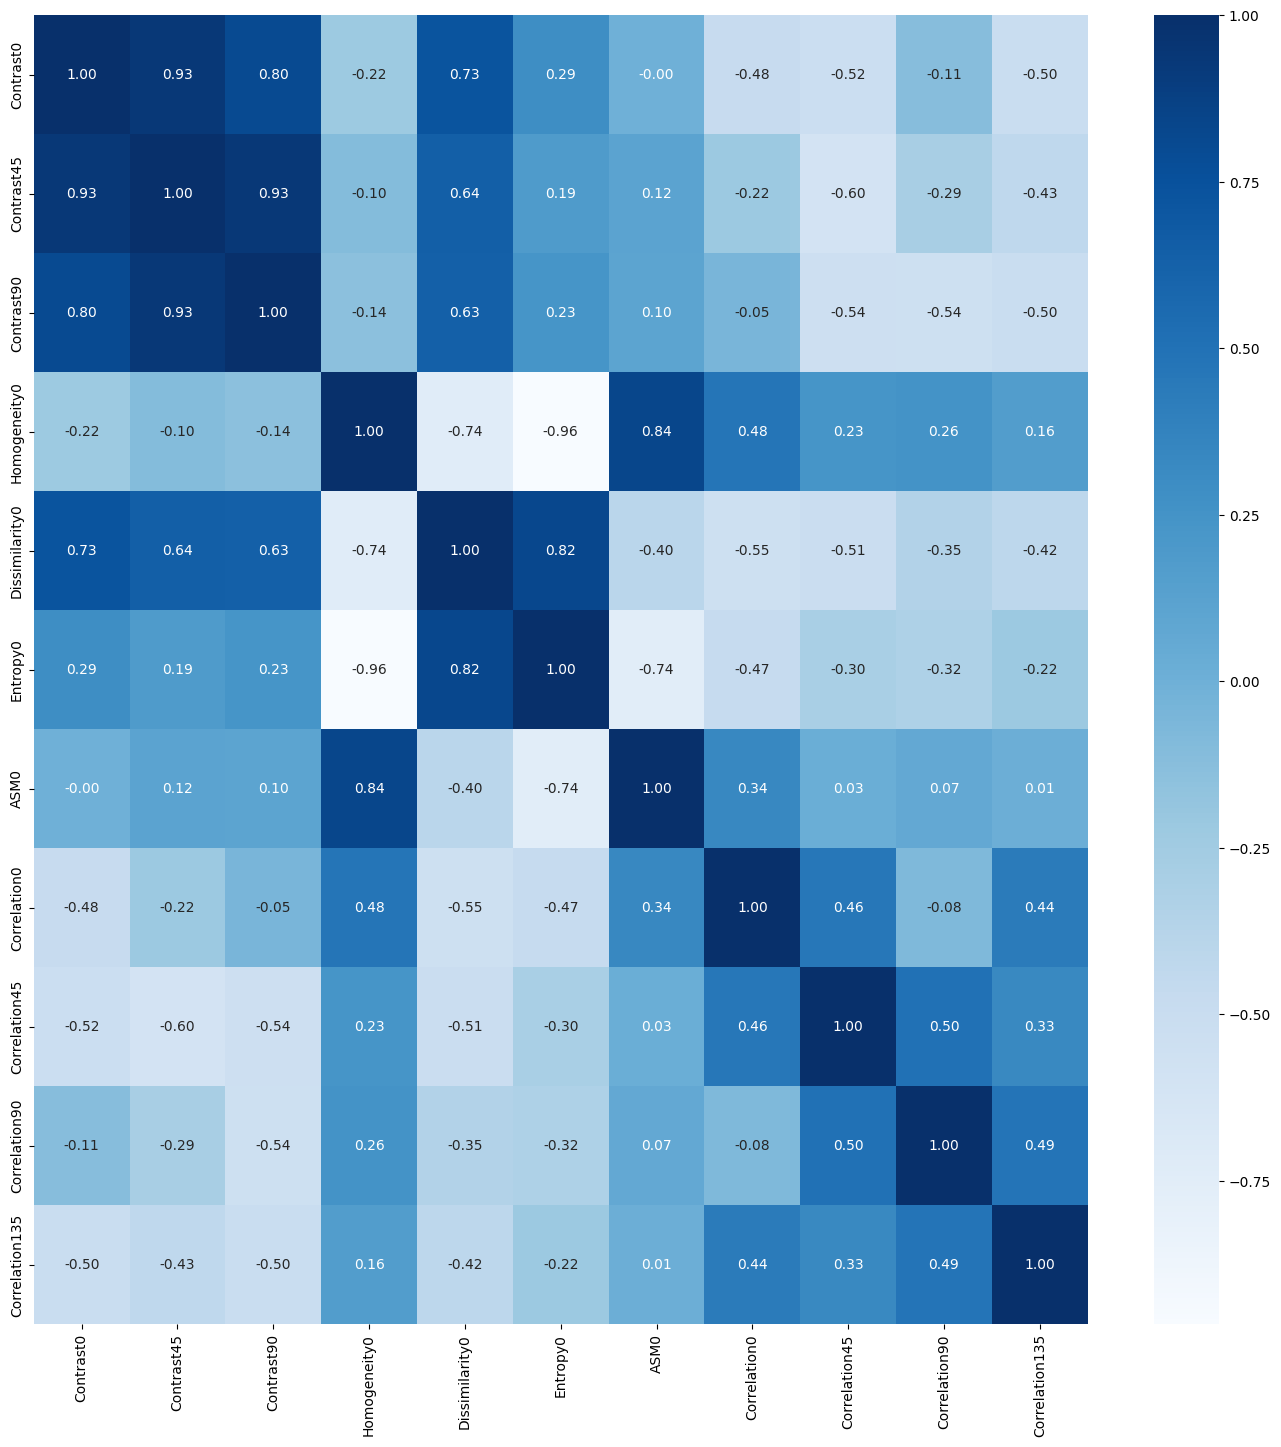

In [12]:
# Selection Correlation
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

### LDA

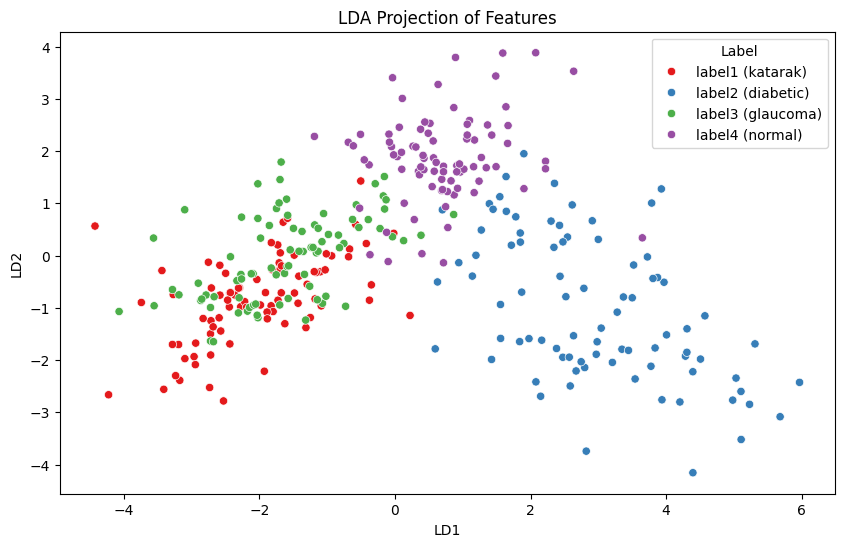

In [13]:
# Selection LDA

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

def feature_reduction_lda(dataframe, n_components=2):
    fitur = dataframe.drop(columns=['Label', 'Filename'])
    label = dataframe['Label']
    
    lda = LinearDiscriminantAnalysis(n_components=n_components)
    x_lda = lda.fit_transform(fitur, label)
    
    columns = [f'LD{i+1}' for i in range(n_components)]
    df_lda = pd.DataFrame(x_lda, columns=columns)
    df_lda['Label'] = label.values
    
    return df_lda

lda_df = feature_reduction_lda(hasilEkstrak, n_components=2)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=lda_df, x='LD1', y='LD2', hue='Label', palette='Set1')
plt.title('LDA Projection of Features')
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend(title='Label')
plt.show()

### t-SNE

C:\Users\VICTUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


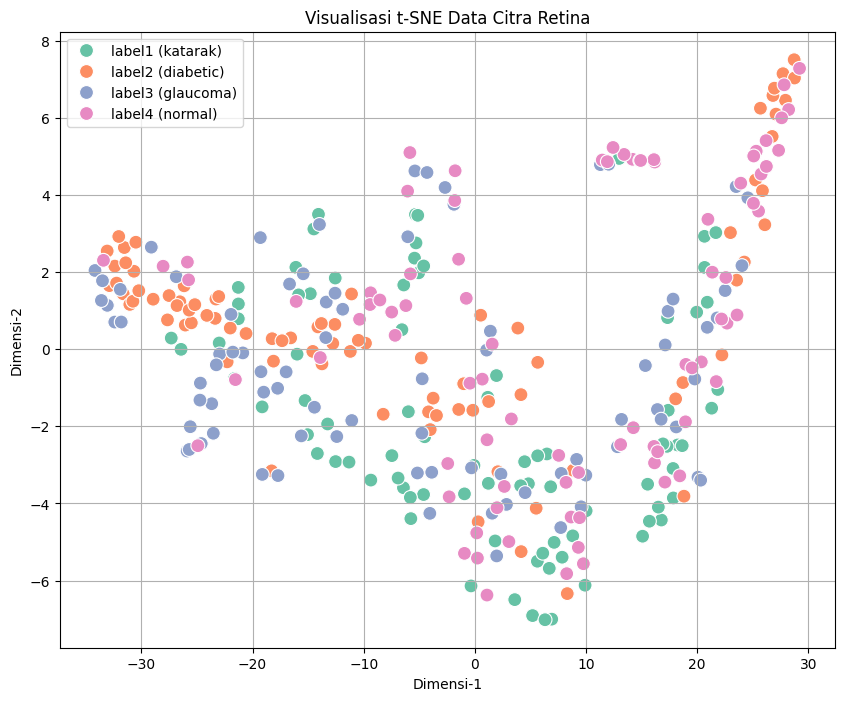

In [14]:
# Selection t-SNE

from sklearn.manifold import TSNE

# Jalankan t-SNE untuk reduksi ke 2 dimensi
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(x_new)

# Buat DataFrame hasil t-SNE
df_tsne = pd.DataFrame()
df_tsne['Dimensi-1'] = X_tsne[:, 0]
df_tsne['Dimensi-2'] = X_tsne[:, 1]
df_tsne['Label'] = y

# Plot dengan seaborn
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='Dimensi-1', y='Dimensi-2', hue='Label', data=df_tsne, palette='Set2', s=100
)
plt.title('Visualisasi t-SNE Data Citra Retina')
plt.legend(loc='best')
plt.grid(True)
plt.show()


## Splitting Data

In [15]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(268, 11)
(68, 11)
(268,)
(68,)


## Feature Normalization



In [16]:
# normalisasi mean std (Standardization / Z-score normalization)
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

## Modeling

### Define Model

In [17]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

### Train Random Forest Classifier

In [18]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
                   precision    recall  f1-score   support

 label1 (katarak)       0.95      0.97      0.96        64
label2 (diabetic)       0.99      0.99      0.99        67
label3 (glaucoma)       0.95      0.96      0.95        72
  label4 (normal)       1.00      0.97      0.98        65

         accuracy                           0.97       268
        macro avg       0.97      0.97      0.97       268
     weighted avg       0.97      0.97      0.97       268

[[62  0  2  0]
 [ 0 66  1  0]
 [ 3  0 69  0]
 [ 0  1  1 63]]
Accuracy: 0.9701492537313433

------Testing Set------
                   precision    recall  f1-score   support

 label1 (katarak)       0.70      0.80      0.74        20
label2 (diabetic)       0.89      1.00      0.94        17
label3 (glaucoma)       0.69      0.75      0.72        12
  label4 (normal)       1.00      0.68      0.81        19

         accuracy                           0.81        68
        macro avg       0.82 

### Train SVM Classifier

In [19]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
                   precision    recall  f1-score   support

 label1 (katarak)       0.76      0.89      0.82        64
label2 (diabetic)       1.00      0.87      0.93        67
label3 (glaucoma)       0.80      0.74      0.77        72
  label4 (normal)       0.87      0.92      0.90        65

         accuracy                           0.85       268
        macro avg       0.86      0.85      0.85       268
     weighted avg       0.86      0.85      0.85       268

[[57  0  6  1]
 [ 0 58  2  7]
 [18  0 53  1]
 [ 0  0  5 60]]
Accuracy: 0.8507462686567164

------Testing Set------
                   precision    recall  f1-score   support

 label1 (katarak)       0.88      0.75      0.81        20
label2 (diabetic)       0.79      0.88      0.83        17
label3 (glaucoma)       0.62      0.83      0.71        12
  label4 (normal)       0.88      0.74      0.80        19

         accuracy                           0.79        68
        macro avg       0.79

### Train KNN Classifier

In [20]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)



------Training Set------
                   precision    recall  f1-score   support

 label1 (katarak)       0.77      0.86      0.81        64
label2 (diabetic)       0.93      0.84      0.88        67
label3 (glaucoma)       0.77      0.76      0.77        72
  label4 (normal)       0.88      0.89      0.89        65

         accuracy                           0.84       268
        macro avg       0.84      0.84      0.84       268
     weighted avg       0.84      0.84      0.84       268

[[55  0  8  1]
 [ 0 56  4  7]
 [14  3 55  0]
 [ 2  1  4 58]]
Accuracy: 0.835820895522388

------Testing Set------
                   precision    recall  f1-score   support

 label1 (katarak)       0.86      0.90      0.88        20
label2 (diabetic)       0.78      0.82      0.80        17
label3 (glaucoma)       0.78      0.58      0.67        12
  label4 (normal)       0.85      0.89      0.87        19

         accuracy                           0.82        68
        macro avg       0.82 

## Evaluasi Dengan Confussion Matrix

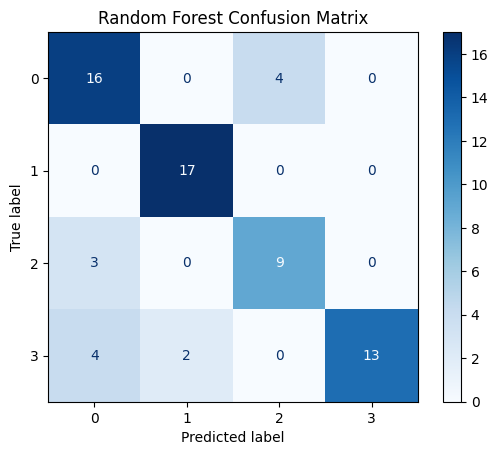

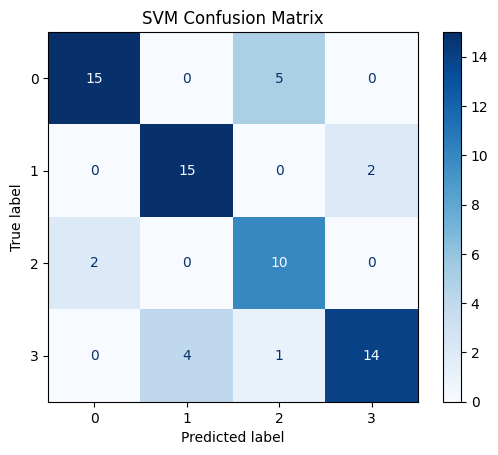

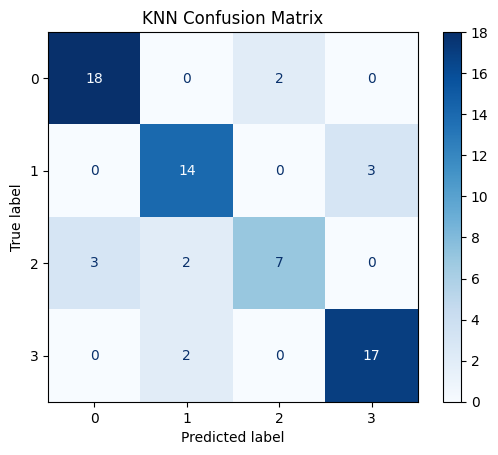

In [21]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")